In [1]:
# !pip install seaborn 1> /dev/null # 1> means redirect stdout

# Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, classification_report, make_scorer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
pd.set_option('display.max_rows', 500)
random_state = 42
np.random.seed(random_state)
data_filepath = './data/'
# data_filepath = '/kaggle/input/child-mind-institute-problematic-internet-use/'

# Data

In [2]:
!du -hs $data_filepath*
train_df = pd.read_csv(data_filepath + 'train.csv')
test_df = pd.read_csv(data_filepath + 'test.csv')
train_df.shape, test_df.shape

6.2G	./data/child-mind-institute-problematic-internet-use.zip
 12K	./data/data_dictionary.csv
4.0K	./data/sample_submission.csv
7.9M	./data/series_test.parquet
6.3G	./data/series_train.parquet
8.0K	./data/test.csv
924K	./data/train.csv


((3960, 82), (20, 59))

In [3]:
train_df.sii.value_counts(dropna=False)

sii
0.0    1594
NaN    1224
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [4]:
# sns.relplot(train_df, x='Basic_Demos-Age', y='PCIAT-PCIAT_Total', hue='sii', kind='line', aspect=2.5)

In [5]:
cols_to_drop = ['sii', 'id']
X, y = train_df.drop(columns=cols_to_drop), train_df.sii
X.shape, y.shape

((3960, 80), (3960,))

In [6]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

# KNN

In [23]:
numeric_transormer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    # ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
])  
category_transormer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder()),
])
cols_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transormer, num_cols),
    ('category', category_transormer, cat_cols),
])
preproc_df_pipe = Pipeline(steps=[
    ('cols_transformer', cols_transformer),
    ('scaler', StandardScaler()),
    # ('nomralize', Normalizer(norm='l2')),
])
preproc_df_pipe

Pipeline(steps=[('cols_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Basic_Demos-Age',
                                                   'Basic_Demos-Sex',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',
                                                   'Physical-HeartRate',
                                                   'Physical-Systolic_BP',
                                                   'Fitness_Endurance-M...
                                                   'BIA-BIA_BMC', 'BIA-BIA_BMI', ...]),
                                                 ('category',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Basic_Demos-Enroll_Season',
                                                   'CGAS-Season',
                                                   'Physical-Season',
                                                   'Fitness_Endurance-Season',
                                                   'FGC-Season', 'BIA-Season',
                                                   'PAQ_A-Season',
                                                   'PAQ_C-Season',
                                                   'PCIAT-Season', 'SDS-Season',
                                                   'PreInt_EduHx-Season'])])),
                ('scaler', StandardScaler())])

In [41]:
preproc_X = preproc_df_pipe.fit_transform(X)
preproc_X = pd.DataFrame(preproc_X, columns=X.columns)
preproc_X['sii'] = y
preproc_X = pd.DataFrame(KNNImputer(n_neighbors=2).fit_transform(preproc_X), columns=preproc_X.columns)
preproc_X['sii'] = preproc_X['sii'].round()
preproc_X

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,-1.520226,-0.770846,-8.276215e-01,-5.495410e-01,-1.522486e+00,-9.736299e-01,5.162127e-13,-1.112312e-13,5.887927e-14,-2.314926e-14,...,-1.377057,-0.220746,-1.396135,-2.009326,0.280843,-0.317978,-1.409839,-0.358580,-1.373279,2.0
1,-0.401093,-0.770846,-9.031580e-14,-1.185749e+00,-1.216358e+00,-1.095847e+00,-1.992136e+00,4.552580e-01,-9.806198e-01,3.405206e-01,...,-1.377057,-0.220746,-1.396135,1.570040,0.280843,-1.606817,-1.409839,-1.434321,0.513342,0.0
2,-0.121310,1.297277,3.174973e-01,-6.007246e-01,8.468847e-02,-3.421734e-01,5.162127e-13,-3.955246e-01,1.048732e+00,1.148855e-03,...,-1.377057,-1.684994,-1.396135,0.376918,0.280843,0.970860,-1.409839,-1.434321,0.513342,0.0
3,-0.401093,-0.770846,3.174973e-01,-2.327425e-01,8.156347e-03,-1.894017e-01,5.162127e-13,-8.209160e-01,1.302401e+00,1.148855e-03,...,0.579930,1.243501,0.602309,0.376918,0.280843,2.259698,0.717815,0.717160,1.456652,1.0
4,2.116955,1.297277,-9.031580e-14,1.049908e-13,1.653132e-13,-4.703870e-15,5.162127e-13,-1.112312e-13,5.887927e-14,-2.314926e-14,...,-0.398563,-0.220746,-0.396913,0.376918,-1.411911,-0.317978,-0.346012,-0.358580,-0.429968,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,0.718039,-0.770846,-3.123180e-01,-6.648073e-01,5.438812e-01,-1.690321e-01,5.162127e-13,1.149449e-01,-9.806198e-01,-8.812177e-01,...,-1.377057,-0.220746,-1.396135,-2.009326,0.280843,2.259698,1.781641,1.792901,-1.373279,1.0
3956,-0.121310,-0.770846,-9.031580e-14,-1.269966e-01,-3.745043e-01,-3.218039e-01,-1.051103e-01,-8.209160e-01,-3.041691e-01,6.902320e-02,...,-0.398563,-0.220746,-0.396913,-0.816204,0.280843,2.259698,-0.346012,-0.358580,1.456652,0.0
3957,0.158473,-0.770846,1.457295e-01,4.722928e-01,6.204133e-01,5.286255e-01,5.162127e-13,7.955710e-01,1.471514e+00,-6.672549e-02,...,1.558424,-0.220746,1.601531,1.570040,0.280843,2.259698,1.781641,1.792901,-1.373279,1.0
3958,0.718039,-0.770846,2.602414e-01,-1.588667e+00,2.258201e+00,-5.190713e-02,5.162127e-13,-9.059942e-01,-1.741627e+00,-2.703485e-01,...,1.558424,-0.220746,-0.396913,0.376918,0.280843,-0.317978,-0.346012,-0.358580,-0.429968,0.0


In [39]:
y.value_counts(dropna=False).sort_index()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
NaN    1224
Name: count, dtype: int64

In [42]:
preproc_X.sii.value_counts(dropna=False).sort_index()

sii
0.0    2795
1.0     753
2.0     378
3.0      34
Name: count, dtype: int64

# Target missing fill by KMeans

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
class GroupByImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_by_col, drop_group_by_col=False):
        self.group_by_col = group_by_col
        self.drop_group_by_col = drop_group_by_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.drop_group_by_col:
            X = X.groupby([self.group_by_col]).transform(lambda x: x.fillna( x.mean() is not np.nan and x.mean() and x.mean() or (x.mean() is np.nan and 9) ).astype(x.dtype))
        else:
            X.loc[:,[c for c in X.columns if c != self.group_by_col]] = X.groupby([self.group_by_col]).transform(lambda x: x.fillna( x.mean() is not np.nan and x.mean() and x.mean() or (x.mean() is np.nan and 9) ).astype(x.dtype))
        return X

numeric_transormer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='mean')),
    ('imputer', GroupByImputer(group_by_col='Basic_Demos-Enroll_Season', drop_group_by_col=True)),
    # ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
])  
category_transormer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder()),
])
cols_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transormer, num_cols + ['Basic_Demos-Enroll_Season']),
    # ('category', category_transormer, cat_cols),
])
preproc_df_pipe = Pipeline(steps=[
    ('cols_transformer', cols_transformer),
    ('scaler', StandardScaler()),
    ('nomralize', Normalizer(norm='l2')),
])
# kmeans_pipe = Pipeline(steps=[
#     ('preproc', preproc_df_pipe),
#     ('pca', PCA(n_components=3, random_state=random_state)),
#     ('cluster', MiniBatchKMeans(n_clusters=2, random_state=random_state)),
# ])

# kmeans_pipe
preproc_df_pipe

Pipeline(steps=[('cols_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   GroupByImputer(drop_group_by_col=True,
                                                                                  group_by_col='Basic_Demos-Enroll_Season'))]),
                                                  ['Basic_Demos-Age',
                                                   'Basic_Demos-Sex',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',...
                                                   'Fitness_Endurance-Time_Sec',
                                                   'FGC-FGC_CU',
                                                   'FGC-FGC_CU_Zone',
                                                   'FGC-FGC_GSND',
                                                   'FGC-FGC_GSND_Zone',
                                                   'FGC-FGC_GSD',
                                                   'FGC-FGC_GSD_Zone',
                                                   'FGC-FGC_PU',
                                                   'FGC-FGC_PU_Zone',
                                                   'FGC-FGC_SRL',
                                                   'FGC-FGC_SRL_Zone',
                                                   'FGC-FGC_SRR',
                                                   'FGC-FGC_SRR_Zone',
                                                   'FGC-FGC_TL',
                                                   'FGC-FGC_TL_Zone',
                                                   'BIA-BIA_Activity_Level_num',
                                                   'BIA-BIA_BMC', 'BIA-BIA_BMI', ...])])),
                ('scaler', StandardScaler()), ('nomralize', Normalizer())])

<Axes: xlabel='tsne1', ylabel='tsne2'>

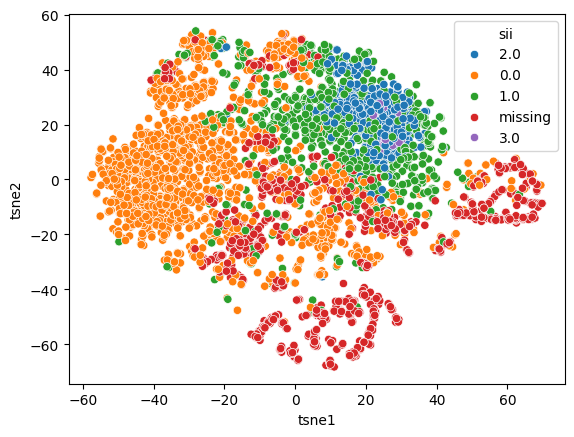

In [15]:
preproc_X = preproc_df_pipe.fit_transform(X)
tsne = TSNE(n_components=2).fit_transform(preproc_X)
tsne = pd.DataFrame(tsne, columns=[f'tsne{i}' for i in range(1, tsne.shape[1]+1)])
tsne['sii'] = y.fillna('missing')
sns.scatterplot(data=tsne, x='tsne1', y='tsne2', hue='sii')

CPU times: user 195 ms, sys: 122 ms, total: 317 ms
Wall time: 38.1 ms


<Axes: xlabel='pca1', ylabel='pca2'>

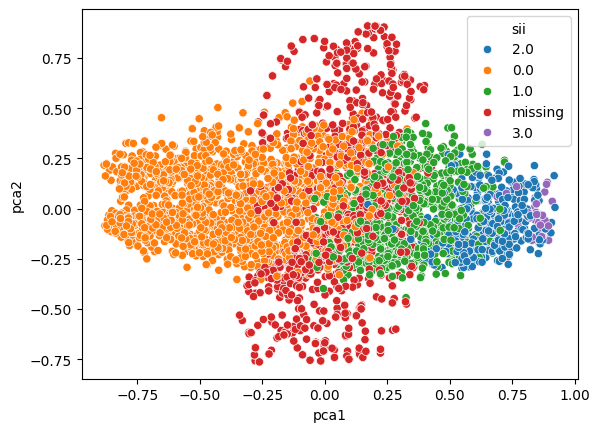

In [16]:
%%time
pca = PCA(n_components=2, random_state=random_state).fit_transform(preproc_X)
pca = pd.DataFrame(pca, columns=[f'pca{i}' for i in range(1, pca.shape[1]+1)])
pca['sii'] = y.fillna('missing')
sns.scatterplot(data=pca, x='pca1', y='pca2', hue='sii')

best_cnt_of_clusters=4


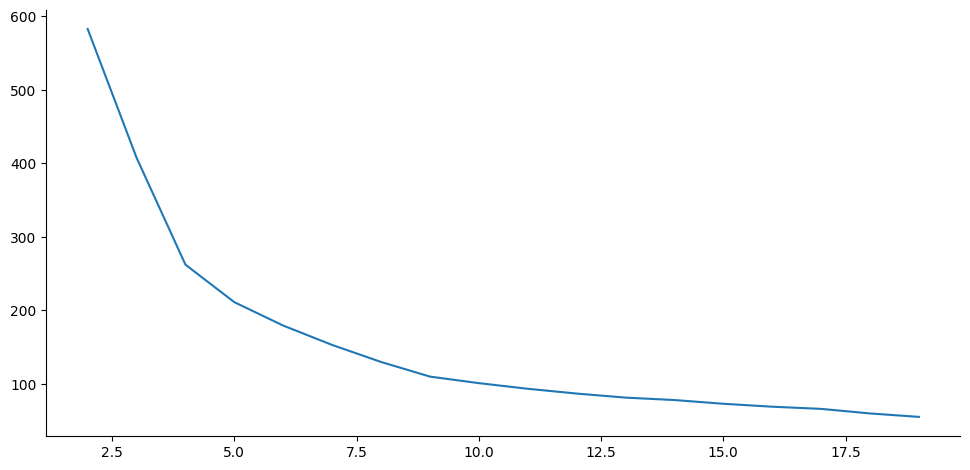

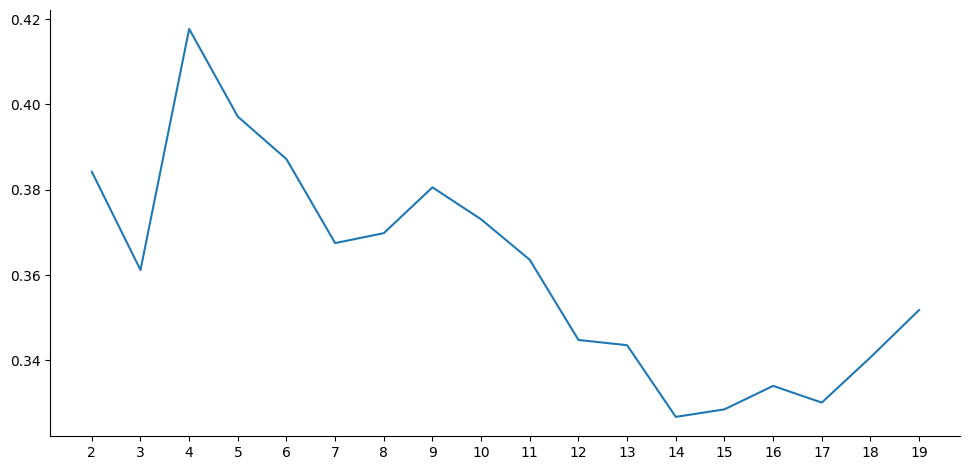

CPU times: user 14.8 s, sys: 21.6 s, total: 36.4 s
Wall time: 3.77 s


In [17]:
%%time
def calc_wcss_silhouette(X, clusters_range=range(3, 10)):
    wcss = list()
    silhouette = list()
    X = PCA(n_components=2, random_state=random_state).fit_transform(X)
    for i in clusters_range:
        cluster = MiniBatchKMeans(n_clusters=i, random_state=random_state)
        labels = cluster.fit_predict(X)
        silhouette.append(silhouette_score(X, labels))
        wcss.append(cluster.inertia_)
    return wcss, silhouette
clusters_range = list(range(2, 20))
preproc_X = preproc_df_pipe.fit_transform(X)
wcss, silhouette = calc_wcss_silhouette(preproc_X, clusters_range)
best_cnt_of_clusters = silhouette.index(max(silhouette)) + clusters_range[0]
print(f'{best_cnt_of_clusters=}')
sns.relplot(x=clusters_range, y=wcss, kind='line', aspect=2)
sns.relplot(x=clusters_range, y=silhouette, kind='line', aspect=2)
import matplotlib.pyplot as plt; plt.xticks(clusters_range) # for x dont round up
plt.show()

In [18]:
cluster = MiniBatchKMeans(n_clusters=best_cnt_of_clusters, random_state=random_state)
preproc_X = preproc_df_pipe.fit_transform(X)
preproc_X = PCA(n_components=2, random_state=random_state).fit_transform(preproc_X)
X_with_clusters = pd.DataFrame(preproc_X, columns=[f'pca{i}' for i in range(1, preproc_X.shape[1]+1)])
X_with_clusters['cluster'] = cluster.fit_predict(preproc_X)
X_with_clusters

,pca1,pca2,cluster
0,0.468470,-0.293068,1
1,-0.711738,-0.086758,0
2,0.009303,0.151568,3
3,0.391096,-0.222617,1
4,0.110999,0.450021,3
...,...,...,...
3955,0.134572,-0.072163,2
3956,0.063011,-0.193217,2
3957,0.142939,-0.062244,2
3958,-0.224738,-0.020965,0


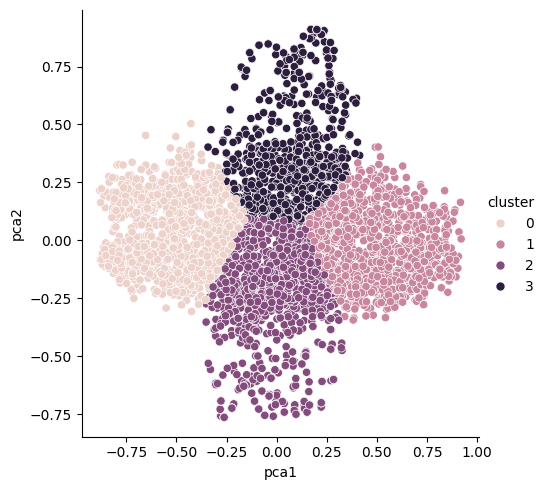

In [19]:
sns.relplot(X_with_clusters, x='pca1', y='pca2', kind='scatter', hue='cluster')

# Clf with kmeans sii missing fill

In [ ]:
cols_to_drop = ['sii', 'id', 'cluster']
train_df = pd.read_csv(data_filepath + 'train.csv')
train_df['cluster'] = train_pca.labels
train_df.loc[train_df.cluster==0, 'sii'] = train_df.loc[train_df.cluster==0, 'sii'].fillna(0.0)
train_df.loc[train_df.cluster==1, 'sii'] = train_df.loc[train_df.cluster==1, 'sii'].fillna(1.0)
train_df.loc[train_df.cluster==2, 'sii'] = train_df.loc[train_df.cluster==2, 'sii'].fillna(0.0)
target_source_cols = [c for c in train_df.columns if c.startswith('PCIAT')]
train_df.drop(columns=target_source_cols, inplace=True)
X, y = train_df.drop(columns=cols_to_drop, errors='ignore'), train_df.sii
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()
X.shape, y.shape

In [ ]:
y.value_counts(dropna=False)

In [ ]:
numeric_transormer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='median')),
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
])  
category_transormer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder()),
])
cols_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transormer, num_cols),
    ('category', category_transormer, cat_cols),
])
preproc_df_pipe = Pipeline(steps=[
    ('cols_transformer', cols_transformer),
    ('scaler', StandardScaler()),
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=random_state)
X_train = preproc_df_pipe.fit_transform(X_train)
X_test = preproc_df_pipe.transform(X_test)

In [ ]:
%%time
clf = CatBoostClassifier()
clf.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    logging_level='Silent', 
)
preds = clf.predict(X_test)
print(cohen_kappa_score(y_test, preds))
print(classification_report(y_test, preds))

# Cross validation

In [ ]:
%%time
_clf = CatBoostClassifier(verbose=0)
cv = StratifiedShuffleSplit(n_splits=5, test_size=.3, random_state=random_state)
_pipeline = Pipeline([('transformer', preproc_df_pipe), ('estimator', _clf)])
scoring = {
    'f1': 'f1_macro',
    'cohen_kappa_score': make_scorer(cohen_kappa_score), 
}
scores = cross_validate(_pipeline, X, y, cv=cv, scoring=scoring)
for metric, folds_score in scores.items():
    if not metric.startswith('test_'): continue
    print(metric, folds_score.mean().round(4), folds_score.std().round(4))

# Save

In [ ]:
test_df = pd.read_csv(data_filepath + 'test.csv')
test_df['sii'] = clf.predict(preproc_df_pipe.transform(test_df[X.columns]))
test_df.sii.value_counts()

In [ ]:
test_df[['id', 'sii']].to_csv('submission.csv', index=False)
!du -hs 'submission.csv'

In [ ]:
# Score: 0.320